# **Import Required Libraries**


In [171]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time
import warnings
warnings.filterwarnings("ignore")

In [172]:
# Check if a GPU is available and set the device accordingly to ensures that the model and data are both on the GPU when available, 
# which can significantly accelerate training and inference for deep learning tasks.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Data Reading**
Read the original datasets and create a dataframe containing the image paths and their corresponding labels

In [173]:

class TumorDataset:
    """
    This class is designed to read two types of original datasets and create a dataframe containing the image paths and their corresponding labels 
    
    Attributes:
        root_dir (str): The root directory where the two types of original datasets are located.
        df_UID_label (pd.DataFrame): A dataframe with two columns, ['UID', 'label'].
        df_image_str_label_path_file (pd.DataFrame): A dataframe with two columns, ['UID', 'Img_path_file'].
        df_image_path_file_label (pd.DataFrame): A dataframe with two columns, ['Img_label', 'Img_path_file'].

    Methods:
        read_uid_label_file(): Reads the CSV file STAN_labels.csv and populates df_UID_label.
        read_image_str_label_path_file(): Reads all image files and populates df_image_str_label_path_file.
        derive_image_path_file_label(): Derives a dataframe with two columns, ['Img_label', 'Img_path_file'].
    """

    def __init__(self, root_dir):
        """
        Initialize a new object of the class.

        Args:
            root_dir (str): The root directory where two types of original datasets are located.

        Attributes:
            root_dir (str): The root directory where the datasets are located.
            df_UID_label (DataFrame): A DataFrame for storing UID-label associations (initially None).
            df_image_str_label_path_file (DataFrame): A DataFrame for storing image string label and path associations (initially None).
        """

        self.root_dir = root_dir
        self.df_UID_label = None  
        self.df_image_str_label_path_file = None


    def read_uid_label_file(self):
        """
        Read the 'STAN_labels.csv' file and populate the 'df_UID_label' DataFrame.

        Returns:
            None

        Note:
            Ensure that the 'root_dir' attribute points to the directory containing the 'STAN_labels.csv' file.
        """

        path_csv_file = self.root_dir+'/labels/STAN_labels.csv'
        df_UID_label = pd.read_csv(path_csv_file)
        self.df_UID_label = df_UID_label
        

    def read_image_str_label_path_file(self):
        """
        Read and collect information from image files to populate the 'df_image_str_label_path_file' DataFrame.

        This method scans the 'patches' directory within the specified 'root_dir' and collects information about image files.
        It then populates the 'df_image_str_label_path_file' DataFrame with the UID (image identifier) and file paths.

        Returns:
            None

        Note:
            Ensure that the 'root_dir' attribute points to the directory containing the 'patches' subdirectory with image files.
    """

        path = self.root_dir +'/patches'
        img_str_label_list = []
        img_path_file_list = []

        for img_UID in os.listdir(path):
            for img_path_file in glob.glob(path+'/'+img_UID+'/'+'*.png'):
                img_str_label_list.append(img_UID)
                img_path_file_list.append(img_path_file)

        #form a dataframe with two columns, ['UID','Img_path_file']
        df_image_str_label_path_file = pd.DataFrame(data={'UID':img_str_label_list, 'Img_path_file':img_path_file_list})
        self.df_image_str_label_path_file = df_image_str_label_path_file

    # Create a dataframe with two columns, ['Img_label','Img_path_file']
    def derive_image_path_file_label(self)->pd.DataFrame:
        """
        Derive a DataFrame with two columns, ['Img_label', 'Img_path_file'] based on existing data.

        This method generates a new DataFrame with two columns: 'Img_label' and 'Img_path_file', by mapping image labels
        from the 'df_UID_label' DataFrame to image paths and filenames in 'df_image_str_label_path_file'.

        Returns:
            pd.DataFrame: The new DataFrame with columns ['Img_label', 'Img_path_file'].

        Note:
            - Ensure that 'df_UID_label' and 'df_image_str_label_path_file' attributes are properly populated.
            - The resulting DataFrame represents image labels and corresponding file paths.
        """

        self.df_UID_label.rename(columns={'MUT_STATUS':'Img_label'}, inplace=True)
        UID_label_dict = dict(zip(self.df_UID_label.UID,self.df_UID_label.Img_label))
        df_image_path_file_label = self.df_image_str_label_path_file.copy()
        df_image_path_file_label['UID']= self.df_image_str_label_path_file['UID'].map(UID_label_dict)
        df_image_path_file_label.rename(columns={'UID':'Img_label'}, inplace=True)

        return df_image_path_file_label




# **Perform Data Reading**

In [174]:
root_dir = '/kaggle/input/stan-datasets/STAN_patches_lbls/STAN_patches_lbls'
tumor_dataset = TumorDataset(root_dir)
tumor_dataset.read_uid_label_file()
tumor_dataset.read_image_str_label_path_file()
df_image_path_file_label = tumor_dataset.derive_image_path_file_label()
df_image_path_file_label.head(5)

,Img_label,Img_path_file
0,1,/kaggle/input/stan-datasets/STAN_patches_lbls/...
1,1,/kaggle/input/stan-datasets/STAN_patches_lbls/...
2,1,/kaggle/input/stan-datasets/STAN_patches_lbls/...
3,1,/kaggle/input/stan-datasets/STAN_patches_lbls/...
4,1,/kaggle/input/stan-datasets/STAN_patches_lbls/...


# **Data Preprocessing and Transformation**

In [175]:
class CustomDataset(Dataset):
    """
    A custom dataset class designed for data preprocessing and transformation for model training.

    Attributes:
        dataframe (pd.DataFrame): The DataFrame containing image path and label data.
        transform (torchvision.transforms.Compose, optional): A PyTorch transformation pipeline for image processing.

    Methods:
        __len__(): Get the size of the dataset.
        __getitem__(idx): Retrieve the specified image and apply the specified transformations.

    """

    def __init__(self, dataframe, transform=None):
        """
        Initialize a CustomDataset object.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing image path and label data.
            transform (torchvision.transforms.Compose, optional): A PyTorch transformation pipeline for image processing.
        """
        
        self.data = dataframe
        self.transform = transform
        

    def __len__(self):
        """
        Get the size of the dataset.

        Returns:
            int: The number of samples in the dataset.
        """

        return len(self.data)
    

    def __getitem__(self, idx):
        """
        Get the specified image by an index and apply the transformation to it.

        Args:
            idx (int): The index of the image path.

        Returns:
            image (PIL.Image.Image): The image data.
            label (int): The image label.
        """
        
        img_path = self.data.iloc[idx, 1]  # image_path column
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 0]  # image_label column

        if self.transform:
            image = self.transform(image)

        return image, label



# **Perform Data Preprocessing and Transformation**

In [176]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image (224, 224)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image
])
custom_dataset = CustomDataset(dataframe=df_image_path_file_label, transform=transform)



# **Data Splitting**
Partition the dataset into training, validation, and testing subsets.

In [177]:
# Split the dataset to get train_dataset, val_dataset and test_dataset
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size, test_size])


In [178]:
# Define the custom CNN model

class TumorClassifier(nn.Module):
    """
    TumorClassifier is a convolutional neural network (CNN) model designed for tumor classification tasks.

    Attributes:
        - conv1 (nn.Conv2d): The first convolutional layer with 3 input channels and 32 output channels.
        - pool (nn.MaxPool2d): A max-pooling layer with a kernel size of 2 and a stride of 2.
        - conv2 (nn.Conv2d): The second convolutional layer with 32 input channels and 64 output channels.
        - fc1 (nn.Linear): The first fully connected layer with 64 * 32 * 32 input features and 128 output features.
        - fc2 (nn.Linear): The second fully connected layer with 128 input features and 2 output features.

    Methods:
        - forward(x): Performs a forward pass through the network.

            Args:
                - x (torch.Tensor): The input data tensor of shape (batch_size, 3, height, width).

            Returns:
                - torch.Tensor: The output tensor representing class scores. Shape depends on the number of classes.

    Example:
        # Create an instance of the model
        model = TumorClassifier().to(device) 

    """

    def __init__(self):
        """
        Initialize the TumorClassifier neural network.

        This constructor sets up the TumorClassifier network architecture by defining its layers and parameters.

        Architecture:
            - Convolutional Layer 1 (conv1): 3 input channels, 32 output channels, kernel size 3x3, padding 1.
            - Max-Pooling Layer (pool): Kernel size 2x2, stride 2.
            - Convolutional Layer 2 (conv2): 32 input channels, 64 output channels, kernel size 3x3, padding 1.
            - Fully Connected Layer 1 (fc1): Input size 64 x 32 x 32, output size 128.
            - Fully Connected Layer 2 (fc2): Input size 128, output size 2 (corresponding to the number of classes).

        Usage:
            Instantiate this class to create a TumorClassifier neural network for classification tasks.
        """
        
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    
    def forward(self, x):
        """
        Perform a forward pass through the TumorClassifier model.

        This method takes the input data tensor 'x' and passes it through the network to compute class scores.
    
        Args:
            x (torch.Tensor): The input data tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output tensor representing class scores. The shape depends on the number of classes.
        """
        
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# **Create a class of model training and evaluation**

In [179]:
class ModelTrainingEvaluation:
    """
    A class for designing model architecture, training the model, and evaluating it on the test set.

    Attributes:
        learning_rate (float): The learning rate hyperparameter for model training.
        batch_size (int): The size of each batch during training.
        num_epochs (int): The total number of training epochs.
        pretrained (bool): Flag to indicate whether to use a pre-trained model.

    Methods:
        create_initial_model():
            Define the model architecture and essential components.

        create_3_loaders():
            Create data loaders for training, validation, and testing sets.

        evaluate_model(model, dataloader, if_plot_conf_mat=False):
            Evaluate the model's performance on a given dataset.

        train_model(model, optimizer, criterion, scheduler, num_epochs, train_loader, validation_loader):
            Train the model using the specified settings.

        save_final_model(model):
            Save the final trained model to a file.
    """

    def __init__(self, learning_rate, batch_size, num_epochs, pretrained=False):
        """
        Initialize a ModelTrainingEvaluation object.

        Args:
            learning_rate (float): The learning rate hyperparameter for model training.
            batch_size (int): The size of each batch during training.
            num_epochs (int): The total number of training epochs.
            pretrained (bool): Flag to indicate whether to use a pre-trained model (default is False).
        """
        
        self.pretrained = pretrained 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs


    # Define the model architecture
    def create_initial_model(self):
        """
        Define the model architecture and essential components.

        Returns:
            model (torch.nn.Module): The initial model.
            optimizer (torch.optim.Optimizer): Adam optimizer.
            criterion (torch.nn.Module): Loss function for training.
            scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler for training.
        """
      
        if self.pretrained:    
            model = models.resnet18(pretrained=True)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 2)  # Modify the final classification layer for binary classification
            model = model.to(device) # Move the model to the GPU if available
        else:
            model = TumorClassifier().to(device)
            
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduling
        return model, optimizer, criterion, scheduler

    # Create 3 data loaders
    def create_3_loaders(self):
        """
        Create data loaders for training, validation, and testing sets.

        Returns:
            train_loader: Iterator for training set batches.
            validation_loader: Iterator for validation set batches.
            test_loader: Iterator for testing set batches.
        """

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        validation_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader, validation_loader, test_loader

    # Evaluate model
    def evaluate_model(self, model, dataloader, if_plot_conf_mat=False):
        """
        Evaluate the model's performance on a specified dataset.

        Args:
            model (torch.nn.Module): The model to evaluate.
            dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset.
            if_plot_conf_mat (bool, optional): If True, plot the confusion matrix; otherwise, do not plot.

        Returns:
            accuracy (float): The accuracy of the model on the given dataset.
        """

        model.eval()
        correct = 0
        total = 0
        if if_plot_conf_mat:
            predictions = torch.tensor([]).to(device)
            true_labels = torch.tensor([]).to(device)
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                if if_plot_conf_mat:
                    predictions = torch.cat((predictions, predicted), dim=0)
                    true_labels = torch.cat((true_labels, labels), dim=0)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total

        if if_plot_conf_mat:
          conf_matrix = confusion_matrix(true_labels.cpu(), predictions.cpu())
          # Plot the confusion matrix
          sns.heatmap(conf_matrix, annot=True, fmt="d")
          plt.xlabel('Predicted')
          plt.ylabel('True')
          plt.title("Confusion Matrix for Test Set")
          plt.show()
        return accuracy

    def train_model(self, model, optimizer, criterion, scheduler, num_epochs, train_loader, validation_loader):
        """
        Train the model using the specified settings.

        Args:
            model (pre-trained or torch.nn.Module): The model to tune or train.
            optimizer (torch.optim.Optimizer): The optimizer for training.
            criterion (torch.nn.Module): Loss function for training.
            scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler for training.
            num_epochs (int): The total number of training epochs.
            train_loader (torch.utils.data.DataLoader): Iterator for training set batches.
            validation_loader (torch.utils.data.DataLoader): Iterator for validation set batches.

        Returns:
            model (torch.nn.Module): The tuned or trained model.
        """
        for epoch in range(self.num_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
                optimizer.zero_grad()
                outputs = model(inputs).to(device)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            scheduler.step()  # Adjust learning rate
            # Evaluate the model on the validation set
            validation_accuracy = self.evaluate_model(model, validation_loader, False)
            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {100 * validation_accuracy:.2f}%')
            print(f'Epoch, Loss: {epoch+1, loss.item()}')
        return model

    def save_final_model(self, model):
        """
        Save the final trained model to a file.

        Args:
            model: The final trained model.
        """    
        
        torch.save(model.state_dict(), 'final_model.pth')


# **Perform model training and evaluation**

Epoch [1/20] - Validation Accuracy: 71.26%
Epoch, Loss: (1, 0.55557781457901)
Epoch [2/20] - Validation Accuracy: 86.21%
Epoch, Loss: (2, 0.3470309376716614)
Epoch [3/20] - Validation Accuracy: 93.10%
Epoch, Loss: (3, 0.14586007595062256)
Epoch [4/20] - Validation Accuracy: 97.70%
Epoch, Loss: (4, 0.10899980366230011)
Epoch [5/20] - Validation Accuracy: 95.40%
Epoch, Loss: (5, 0.2517448365688324)
Epoch [6/20] - Validation Accuracy: 91.95%
Epoch, Loss: (6, 0.018420424312353134)
Epoch [7/20] - Validation Accuracy: 90.80%
Epoch, Loss: (7, 0.03528347238898277)
Epoch [8/20] - Validation Accuracy: 95.40%
Epoch, Loss: (8, 0.028441883623600006)
Epoch [9/20] - Validation Accuracy: 95.40%
Epoch, Loss: (9, 0.02164718694984913)
Epoch [10/20] - Validation Accuracy: 95.40%
Epoch, Loss: (10, 0.0044198427349328995)
Epoch [11/20] - Validation Accuracy: 96.55%
Epoch, Loss: (11, 0.008224692195653915)
Epoch [12/20] - Validation Accuracy: 96.55%
Epoch, Loss: (12, 0.004466133192181587)
Epoch [13/20] - Valid

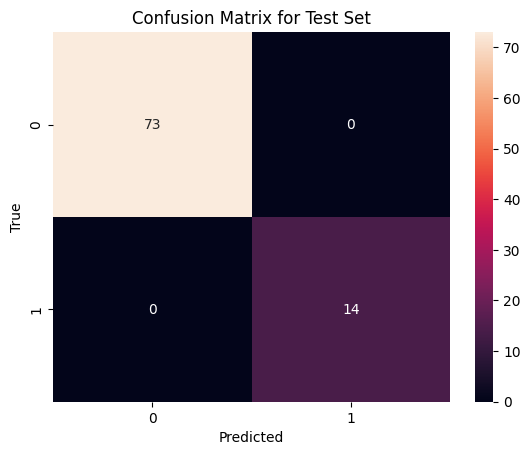

Final test Accuracy: 100.00%
Execution Time: 18.933236122131348 seconds


In [180]:
start_time = time.time()

learning_rate, batch_size, num_epochs = 0.001, 32, 20
model_train_eval = ModelTrainingEvaluation(learning_rate, batch_size, num_epochs, pretrained=True)
model, optimizer, criterion, scheduler = model_train_eval.create_initial_model()
train_loader, validation_loader, test_loader = model_train_eval.create_3_loaders()
model = model_train_eval.train_model(model, optimizer, criterion, scheduler, num_epochs, train_loader, validation_loader)
test_accuracy = model_train_eval.evaluate_model(model, test_loader, True)
print(f'Final test Accuracy: {100 * test_accuracy:.2f}%')
# Save the final model
model_train_eval.save_final_model(model)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")
